# Análisis Exploratorio de Datos (EDA) y Preprocesamiento

Este cuaderno realiza el análisis inicial de los datos bursátiles y los prepara para el modelo GAN.

**Pasos:**
1. Carga Robusta de Datos
2. Visualización (Series Temporales y Volatilidad)
3. Preprocesamiento (Normalización y Ventanas Deslizantes)
4. Conversión a Tensores de PyTorch

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.preprocessing import MinMaxScaler

# Configuración
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (14, 7)

## 1. Carga Robusta de Datos

Cargamos el archivo CSV desde `../data/raw/`. Necesitamos manejar el formato específico de `yfinance` donde las primeras filas contienen metadatos.

In [6]:
# Buscar el archivo CSV
data_dir = '../data/raw'
csv_files = glob.glob(os.path.join(data_dir, '*.csv'))

if not csv_files:
    raise FileNotFoundError("No se encontraron archivos CSV en ../data/raw/")

file_path = csv_files[0]
print(f"Cargando datos desde: {file_path}")

# Cargar CSV manejando el formato de yfinance
# Fila 0: Encabezados (Price, Close, etc.)
# Fila 1: Información del ticker (omitida)
# Fila 2: Encabezado vacío/Fecha (omitida)
df = pd.read_csv(file_path, header=0, skiprows=[1, 2], index_col=0, parse_dates=True)

# Renombrar el índice a 'Date' si no lo es ya
df.index.name = 'Date'

print(f"Forma de los Datos: {df.shape}")
df.head()

Cargando datos desde: ../data/raw/AAPL_2015-01-01_2025-11-29.csv
Forma de los Datos: (2744, 5)


,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.237551,24.705320,23.798600,24.694235,212818400
2015-01-05,23.554735,24.086795,23.368515,24.006986,257142000
2015-01-06,23.556959,23.816338,23.195601,23.619033,263188400
2015-01-07,23.887280,23.987040,23.654503,23.765348,160423600
2015-01-08,24.805086,24.862726,24.097889,24.215387,237458000


## 2. Visualización (EDA)

### Serie Temporal del Precio de Cierre

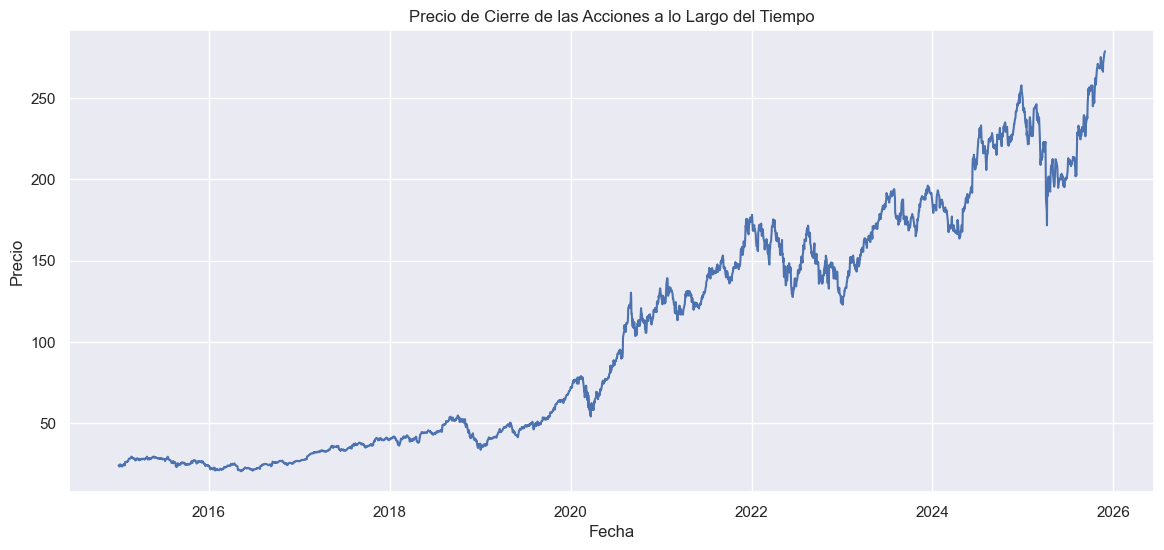

In [7]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x=df.index, y='Close')
plt.title('Precio de Cierre de las Acciones a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.show()

### Distribución de Retornos Logarítmicos
Calculamos los retornos logarítmicos para analizar la volatilidad y la estacionariedad.

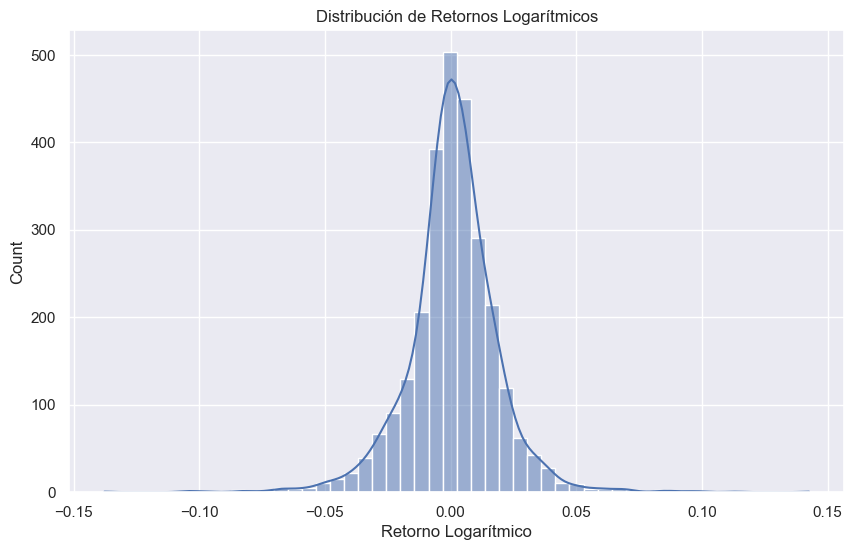

In [8]:
# Calcular Retornos Logarítmicos
df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))

# Eliminar valores NaN creados por el desplazamiento
df_clean = df.dropna()

# Graficar Distribución
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Log_Ret'], kde=True, bins=50)
plt.title('Distribución de Retornos Logarítmicos')
plt.xlabel('Retorno Logarítmico')
plt.show()

## 3. Preprocesamiento para GAN (Ventanas Deslizantes)

Normalizamos los datos y creamos ventanas deslizantes para el modelo.

In [9]:
# Normalizar Datos
scaler = MinMaxScaler(feature_range=(0, 1))
# Usamos el precio de 'Close' para este ejemplo. 
# Redimensionar a (n_samples, 1) para el escalador
data_scaled = scaler.fit_transform(df[['Close']])

print(f"Forma de los Datos Escalados: {data_scaled.shape}")

Forma de los Datos Escalados: (2744, 1)


In [10]:
def create_sequences(data: np.ndarray, seq_len: int) -> np.ndarray:
    """
    Crea secuencias de ventanas deslizantes a partir de los datos.
    
    Args:
        data (np.ndarray): Los datos escalados.
        seq_len (int): La longitud de la secuencia.
        
    Returns:
        np.ndarray: Array de secuencias.
    """
    sequences = []
    for i in range(len(data) - seq_len):
        seq = data[i : i + seq_len]
        sequences.append(seq)
    
    return np.array(sequences)

SEQ_LEN = 24
sequences = create_sequences(data_scaled, SEQ_LEN)

print(f"Forma de las Secuencias: {sequences.shape}")

Forma de las Secuencias: (2720, 24, 1)


## 4. Conversión a Tensores de PyTorch

In [11]:
# Convertir a Tensor
tensor_data = torch.tensor(sequences, dtype=torch.float32)

print(f"Forma Final del Tensor: {tensor_data.shape}")
# Esperado: (Num_Samples, 24, 1)

Forma Final del Tensor: torch.Size([2720, 24, 1])
